In [2]:
!pip install wfdb

In [0]:
!pip install git+https://github.com/google/qkeras 

In [4]:
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scp

sampling_rate=100
ptb = pd.read_csv('/Users/alan/Desktop/ARM_ECG/simulation/ptbdb_normal.csv',header = None)
ptb_ab = pd.read_csv('/Users/alan/Desktop/ARM_ECG/simulation/ptbdb_abnormal.csv',header = None)
print('Normal ECG')
norm = np.array(ptb.iloc[:,:187])

norm_training, norm_test = norm[:int(0.9*norm.shape[0]),:],norm[int(0.9*norm.shape[0]):,:]
print(norm_training.shape, norm_test.shape)
print('Abnormal ECG')
abnorm = np.array(ptb_ab.iloc[:4046,:187])
abnorm_training, abnorm_test = abnorm[:int(0.9*abnorm.shape[0]),:],abnorm[int(0.9*abnorm.shape[0]):,:]
print(abnorm_training.shape, abnorm_test.shape)

x_training = np.vstack((norm_training,abnorm_training))

x_test = np.vstack((norm_test,abnorm_test))
print(x_training.shape,x_test.shape)
y_training_pos = np.ones((norm_training.shape[0],1))
y_training_neg = np.zeros((abnorm_training.shape[0],1))


y_training = np.vstack((y_training_pos,y_training_neg))

y_test_pos = np.ones((norm_test.shape[0],1))
y_test_neg = np.zeros((abnorm_test.shape[0],1))
y_test = np.vstack((y_test_pos,y_test_neg))

print(y_training.shape,y_test.shape)
# np.save("testdata_neg.npy",x_test[500,:])
np.save("romtest.npy",np.vstack((x_test[0:50,:],x_test[405:455,:])))

Normal ECG
(3641, 187) (405, 187)
Abnormal ECG
(3641, 187) (405, 187)
(7282, 187) (810, 187)
(7282, 1) (810, 1)


In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Activation,Dropout,Input
#from tensorflow.keras.utils.vis_utils import plot_model
from qkeras import QActivation, QDense, quantized_bits
import numpy as np

first = Input(shape=(187,))
quant=QActivation("quantized_bits(8)")(first)
x=QDense(5,kernel_quantizer=quantized_bits(8), bias_quantizer=quantized_bits(8))(quant)
x=QActivation('quantized_relu(8)')(x)
x=QDense(10,kernel_quantizer=quantized_bits(8), bias_quantizer=quantized_bits(8))(x)
x=QActivation('quantized_relu(8)')(x)
x=QDense(15,kernel_quantizer=quantized_bits(8), bias_quantizer=quantized_bits(8))(x)
x=QActivation('quantized_relu(8)')(x)
x=QDense(30,kernel_quantizer=quantized_bits(8), bias_quantizer=quantized_bits(8))(x)
x=QActivation('quantized_relu(8)')(x)
x=QDense(15,kernel_quantizer=quantized_bits(8), bias_quantizer=quantized_bits(8))(x)
x=QActivation('quantized_relu(8)')(x)
x=QDense(10,kernel_quantizer=quantized_bits(8), bias_quantizer=quantized_bits(8))(x)
x=QActivation('quantized_relu(8)')(x)
# Dense(5),
# Activation('relu'),
x=QDense(1,kernel_quantizer=quantized_bits(8), bias_quantizer=quantized_bits(8))(x)
output=QActivation('smooth_sigmoid')(x)
model = Model(inputs=first,outputs=output)

# model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# history = model.fit(x_training, y_training, batch_size=32, epochs=60)
# weights = model.get_weights()
# np.save('/content/fixed_point_signed_8bit_weights_quantised.npy',weights)
# saved_weights = model_save_quantized_weights(model, '/content/drive/My Drive/ARM_ECG/Alan_database/fixed_point_signed_8bit_weights_quantised.npy')

weights = np.load('/home/alan/winDesktop/ARM_ECG/simulation/weight.npy',allow_pickle=True)
model.set_weights(weights)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187)]             0         
_________________________________________________________________
q_activation (QActivation)   (None, 187)               0         
_________________________________________________________________
q_dense (QDense)             (None, 5)                 940       
_________________________________________________________________
q_activation_1 (QActivation) (None, 5)                 0         
_________________________________________________________________
q_dense_1 (QDense)           (None, 10)                60        
_________________________________________________________________
q_activation_2 (QActivation) (None, 10)                0         
_________________________________________________________________
q_dense_2 (QDense)           (None, 15)                165   

In [0]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Test loss: 0.29198843240737915
Test accuracy: 0.8888888955116272
Model output: [[0.08267975]] 


Testing Index: 500
Keras simulation on activation layer 1 ==> 
 
Output0: Decimal:0.0000000000000000 	 8bit_binary : 00000000
Output1: Decimal:0.1757812500000000 	 8bit_binary : 00010110
Output2: Decimal:0.7382812500000000 	 8bit_binary : 01011110
Output3: Decimal:0.0000000000000000 	 8bit_binary : 00000000
Output4: Decimal:0.0546875000000000 	 8bit_binary : 00000111

------------END LAYER 1--------------

Keras simulation on activation layer 2 ==> 
 
Output0: Decimal:0.6132812500000000 	 8bit_binary : 01001110
Output1: Decimal:0.6054687500000000 	 8bit_binary : 01001101
Output2: Decimal:0.0000000000000000 	 8bit_binary : 00000000
Output3: Decimal:0.0000000000000000 	 8bit_binary : 00000000
Output4: Decimal:0.0000000000000000 	 8bit_binary : 00000000
Output5: Decimal:0.3398437500000000 	 8bit_binary : 00101011
Output6: Decimal:0.4687500000000000 	 8bit_binary : 00111100
Output7: Decimal:0.1

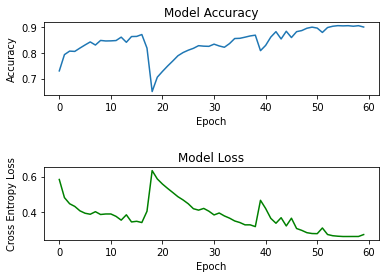

In [17]:
from tensorflow.keras import Model
IDX = 500
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print(f"Model output: {model.predict(np.expand_dims(x_test[IDX ,:],axis =0 ))} \n\n")

fig, axes = plt.subplots(2,1)
axes[0].plot(history.history['accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')

fig.subplots_adjust(hspace=1)

axes[1].plot(history.history['loss'], 'g')
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Cross Entropy Loss')
axes[1].set_xlabel('Epoch')

print(f"Testing Index: {IDX}")
for j in range(1,8):
    print(f"Keras simulation on activation layer {j} ==> \n ")
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(f"q_activation_{j}").output)
    intermediate_output = intermediate_layer_model.predict(np.expand_dims(x_test[500 ,:],axis =0 ))
    Rintermediate_output = np.squeeze(intermediate_output,axis=0)
    # print(Rintermediate_output.shape)
    for i in range(len(Rintermediate_output)):
        print(f"Output{i}: Decimal:{Rintermediate_output[i]:.16f} \t 8bit_binary : {num_to_fixed_point(Rintermediate_output[i])}")
    print(f"\n------------END LAYER {j}--------------\n")



In [0]:
np.save("Testpos.npy",x_test[80,:])
np.save("Testneg.npy",x_test[500,:])

In [0]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 10))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

for i in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(3, 4,
                    subplot_spec=outer[i], wspace=0.5, hspace=0.5)

    for j in range(12):
        ax = plt.Subplot(fig, inner[j])
        # t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i,j))
        # t.set_ha('center') 
        # ax.set_xticks([])
        # ax.set_yticks([])
        if i==0:
            ax.plot(x_test[375+j])
        else:
            ax.plot(x_test[405+j])
        fig.add_subplot(ax)

fig.show()

In [0]:
from tensorflow.keras import Model
from qkeras.utils import model_save_quantized_weights

#saved_weights = model_save_quantized_weights(model, '/content/drive/My Drive/ARM_ECG/Alan_database/fixed_point_signed_8bit_weights_quantised.npy')

weights_dictionary = {}
biases_dictionary = {}

#print(saved_weights["q_dense_64"]['weights'][0])

for layer in saved_weights:
  layer_weights = saved_weights[layer]['weights']
  weights = layer_weights[0]
  biases = layer_weights[1]

  tmp_weights = np.empty(shape=weights.shape, dtype=object)
  for i in range(0,tmp_weights.shape[0]):
    for j in range(0,tmp_weights.shape[1]):
      tmp_weights[i][j] = num_to_fixed_point(weights[i][j])
  tmp_biases = np.empty(shape=biases.shape, dtype=object)
  for i in range(0,tmp_biases.shape[0]):
    tmp_biases[i] = num_to_fixed_point(biases[i])

  weights_dictionary[layer] = tmp_weights
  biases_dictionary[layer] = tmp_biases
  
np.save('/content/drive/My Drive/ARM_ECG/Alan_database/weight_dictionary.npy',weights_dictionary)
np.save('/content/drive/My Drive/ARM_ECG/Alan_database/biases_dictionary.npy',biases_dictionary)


#print(weights_dictionary["q_dense_57"])
print(x_test.shape)
i = 0
for layer in model.layers:
  if i%2==1:
    tmp_list = []
    for i in range(810):
      tmp_model = Model(inputs=first ,outputs=layer.output)
      intermediate = tmp_model.predict(x_test[i,:])
      print(intermediate.shape)
  i+=1

#x_test_quantised = transformer.predict(x_test)

#inputs = np.empty(shape=weights.shape, dtype=object)
#for i in range(0,tmp_weights.shape[0]):
#  for j in range(0,tmp_weights.shape[1]):
#    tmp_weights[i][j] = num_to_fixed_point(weights[i][j])

(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)
(187, 1)


KeyboardInterrupt: ignored

In [0]:
tmp = np.load('/content/drive/My Drive/ARM_ECG/Alan_database/weight_dictionary.npy',allow_pickle=True)
print(tmp.item().get('key'))

[['11111000' '00001111' '00000010' '11101101' '11110010']
 ['11001011' '00011001' '11100001' '00000001' '11100101']
 ['00100111' '11110000' '00001000' '11101000' '00111111']
 ['01111101' '11100001' '00000010' '11101110' '11011001']
 ['01100011' '11011101' '00001101' '11010010' '11111010']
 ['01100100' '11100110' '00000010' '11101110' '00101111']
 ['00000010' '00001000' '11001110' '00010110' '11100100']
 ['11001111' '00100001' '11011010' '00000001' '11111100']
 ['11100110' '00011111' '11101110' '00000101' '11111100']
 ['11100110' '00001110' '00000000' '00010000' '00010001']
 ['11011011' '00000000' '11110001' '00000000' '00000111']
 ['11100011' '00001001' '00000100' '00000101' '00011000']
 ['11100010' '00001101' '00001100' '11111111' '11110000']
 ['11110001' '11110110' '11110110' '11110111' '00001001']
 ['11101110' '11111100' '00000110' '11111001' '00010100']
 ['11100101' '00000001' '00011101' '11111011' '00000011']
 ['00000110' '00001000' '11111111' '11100010' '00000111']
 ['00000010' '